In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
rents = pd.read_csv('rental_info.csv')


print(rents.info())
print(rents[['rental_date','return_date']].head())
print(rents['special_features'].value_counts())
print(rents.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB
None
                 rental_d

Several takeaways from the explotratory analysis:
- The columns rental_date and return_date are objects including date and time
- The column special_features is a srting, yet contain severl groups and needs to be splited to other columns of 0 and 1
- There are no missing values to impute 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   rental_date         15861 non-null  datetime64[ns, UTC]
 1   return_date         15861 non-null  datetime64[ns, UTC]
 2   rental_length_days  15861 non-null  int64              
dtypes: datetime64[ns, UTC](2), int64(1)
memory usage: 371.9 KB
None
0    3
1    2
2    7
3    2
4    4
Name: rental_length_days, dtype: int64


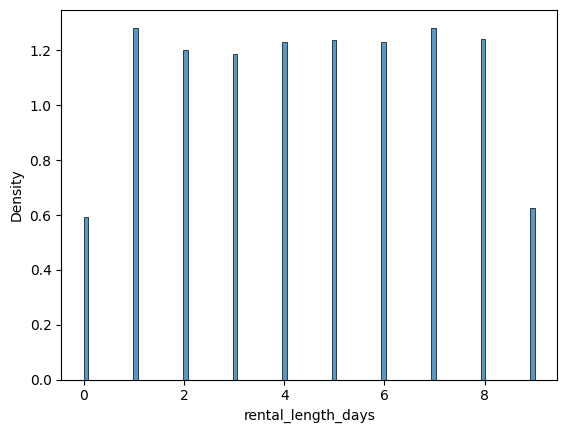

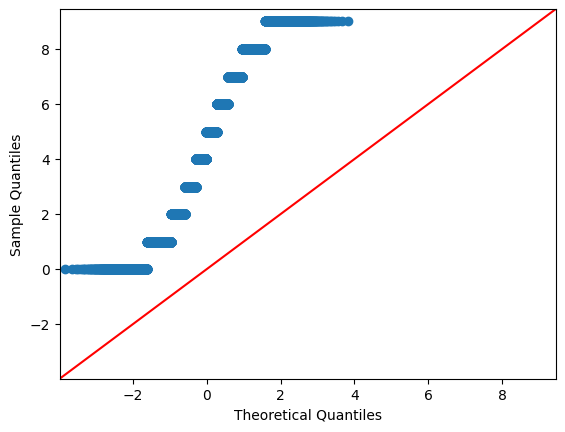

In [7]:
# Convert the rental_date and return_date to datetime types and add the column rental_length_days

from datetime import datetime, timedelta
import statsmodels.api as sm

rents['rental_date'] = pd.to_datetime(rents['rental_date'],format = 'ISO8601')
rents['return_date'] = pd.to_datetime(rents['return_date'],format = 'ISO8601')

rents['rental_length_days'] = (rents['return_date'] - rents['rental_date']).dt.days


print(rents[['rental_date','return_date','rental_length_days']].info())

print(rents['rental_length_days'].head())

# Explore the distribution of the rental_length_dates in order to derive implications for the model
sns.histplot(data = rents['rental_length_days'], 
             bins = 100,   
             linewidth=0.5,
             stat = 'density'
             )

sm.qqplot(rents['rental_length_days'], line='45')

plt.show()

In [10]:
# Split the special_features Deleted Scenes and Behind the Scenes to dummy columns per project's instructions


print(rents['special_features'].head(20))

rents['deleted_scenes'] = np.where(rents['special_features'].str.contains('Deleted Scenes'),1,0)
rents['behind_the_scenes'] = np.where(rents['special_features'].str.contains('Behind the Scenes'),1,0)

# Test the split output

print(rents.loc[0,'behind_the_scenes'], 
      rents.loc[0,'deleted_scenes'],
      rents.loc[0,'special_features'])

index_test = rents[rents['special_features'].str.contains('Deleted Scenes') == True].index[0]
index_test_2 = rents[rents['special_features'].str.contains('Behind the Scenes') == False].index[0]

print(rents.loc[index_test,'deleted_scenes'], 
      rents.loc[index_test,'special_features'])
print(rents.loc[index_test_2,'behind_the_scenes'],
      rents.loc[index_test_2,'special_features'])


0     {Trailers,"Behind the Scenes"}
1     {Trailers,"Behind the Scenes"}
2     {Trailers,"Behind the Scenes"}
3     {Trailers,"Behind the Scenes"}
4     {Trailers,"Behind the Scenes"}
5     {Trailers,"Behind the Scenes"}
6     {Trailers,"Behind the Scenes"}
7     {Trailers,"Behind the Scenes"}
8     {Trailers,"Behind the Scenes"}
9     {Trailers,"Behind the Scenes"}
10    {Trailers,"Behind the Scenes"}
11    {Trailers,"Behind the Scenes"}
12    {Trailers,"Behind the Scenes"}
13    {Trailers,"Behind the Scenes"}
14    {Trailers,"Behind the Scenes"}
15    {Trailers,"Behind the Scenes"}
16    {Trailers,"Behind the Scenes"}
17    {Trailers,"Behind the Scenes"}
18    {Trailers,"Behind the Scenes"}
19    {Trailers,"Behind the Scenes"}
Name: special_features, dtype: object
1 0 {Trailers,"Behind the Scenes"}
1 {"Deleted Scenes","Behind the Scenes"}
0 {Trailers}


In [12]:
# Prepare a dataframe for a regression model
# Note that I dropped the rental and return dates due to the project's instructions

X = rents.drop(['rental_date','return_date','special_features','rental_length_days'], axis =1) 
y = rents['rental_length_days']



In [13]:
# Split the data

SEED = 9

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.2,
                                                    random_state= SEED
                                                    )


In [14]:
rf = RandomForestRegressor(random_state = SEED) # The project focused on random forest models


params_rf = {
             'n_estimators': np.arange(1,101,1),
             'max_depth': np.arange(1,11,1)
}

# Tuning more hyper parameters led to a higher MSE and a model that did not generalize well

grid_rf = RandomizedSearchCV(rf,
                             param_distributions= params_rf,
                             cv= 5,
                             scoring= 'neg_mean_squared_error')

grid_rf.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=9),
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])},
                   scoring='neg_mean_squared_error')

In [17]:
# Show the best params

best_hyperparameters = grid_rf.best_params_
print(best_hyperparameters)

# Pull the best model/estimator

best_model = grid_rf.best_estimator_

# Calculate the MSE
y_pred = best_model.predict(X_test)
best_mse = MSE(y_pred,y_test)
print(best_mse)

rmse = round(best_mse**(1/2),2)

print(f"The model will make predictions with an AVG error of +/- {rmse} days")


{'n_estimators': 12, 'max_depth': 10}
2.249042600410423
The model will make predictions with an AVG error of +/- 1.5 days
